In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import scipy.stats as ss

filename = "NYPD_Complaint_Data_Filtered.csv"
data_raw = np.genfromtxt(filename, dtype=None, delimiter=',', skip_header=True, usecols=range(17),filling_values=None, encoding='UTF-8')

data = np.empty((11065, 8), dtype=object)



In [111]:
age_converter = {'<18': 18.0, '18-24': 22.0, '25-44': 35.0, '45-64': 55, '65+': 65}

In [121]:
for i, row in enumerate(data_raw):
    
    start_date = [int(i) for i in row[1].split('/')]
    end_date = [int(i) for i in row[3].split('/')]
    delta = date(end_date[2], end_date[0],end_date[1]) - date(start_date[2], start_date[0],start_date[1])
    
    duration = (row[4] - row[2]) + (24.0 * delta.days) + 1 # duration in hours, ceiling values
    law_cat = row[5]
    suspect_age = row[7]
    victim_age = row[10]
    suspect_sex = 'M' if row[9] == 'M' else 'F'
    victim_sex = 'M' if row[12] == 'M' else 'F'
    
    entry = np.array([law_cat, str(start_date[1]), str(start_date[0]), str(duration), suspect_age, suspect_sex, victim_age, victim_sex])
    data[i] = entry
    
np.savetxt("NYPD_Complaint_Data_Processed_1.csv", data, delimiter=",",fmt="%.18s", header="law_category,crime_day,crime_month,duration_hours,suspect_age,suspect_sex,victim_age,victim_sex")    

In [145]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

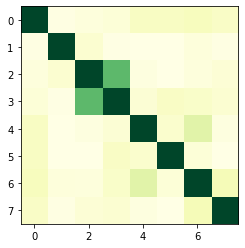

In [150]:
size = entry.size
matrix = np.ones((size,size))

for i in range(0, size):
    for j in range(i+1, size):
        x = data[:, i].reshape(data.shape[0])
        y = data[:, j].reshape(data.shape[0])
        correlation = cramers_v(x, y)
        matrix[i][j] = correlation
        matrix[j][i] = correlation

# print(correlation_ratio(data[:, 0].reshape(data.shape[0]), data[:, 3].reshape(data.shape[0])))

plt.imshow(matrix, cmap='YlGn')
plt.show()


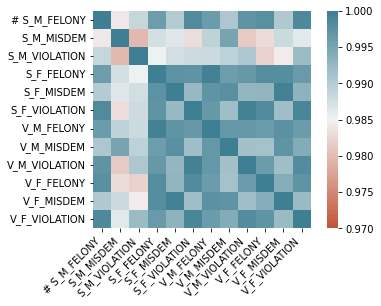

In [86]:
month_data = pd.read_csv('NYPD_Complaint_Data_By_Month.csv')
corr2 = month_data.corr()
ax = sns.heatmap(
    corr2, 
    vmin=0.97, vmax=1, center=0.985,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);